In [0]:
from google.colab import drive
import os
from numpy import array

import numpy as np

import matplotlib.pyplot as plt
from keras.models import load_model
from keras.models import model_from_json
import json
import skimage.morphology as morp
from skimage.filters import rank

drive.mount('/content/gdrive')

effect_type="MOTIONBLUR"
effect_type_2 = "DARKNESS"
effect_type_3 = "RAIN"
effect_type_4 = "BACKLIGHTSUN"


root_path = 'gdrive/My Drive/data_output/'
final_model_path = root_path + "/TSD/h_files/" + "{}.h5".format(effect_type)


Using TensorFlow backend.


# LOADS CNN models 

In [0]:
print("Loading {}".format(effect_type))
deep_cnn_mb = load_model(root_path + "TSD/h_files/deepCNN" + "{}.h5".format(effect_type))

print("Loading {}".format(effect_type_2))
deep_cnn_darkness = load_model(root_path + "TSD/h_files/deepCNN" + "{}.h5".format(effect_type_2))

print("Loading {}".format(effect_type_3))
deep_cnn_rain = load_model(root_path + "TSD/h_files/deepCNN" + "{}.h5".format(effect_type_3))


print("Loading {}".format(effect_type_4))
deep_backlight_sun = load_model(root_path + "TSD/h_files/deepCNN" + "{}.h5".format(effect_type_4))

Loading MOTIONBLUR
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Loading DARKNESS
Loading RAIN
Loading BACKLIGHTSUN


# Preprocessing for the Random Images 

In [0]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image


def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    #normalized_images = normalized_images[..., None]
    return normalized_images


def create_test_dataset(data_set, lk_path):
    new_test_images = []
    correct_labels = []
    for column, row in data_set.iterrows():
        img_id = row['full_img_pth']
       
        class_num = 0
        if '75' in img_id:
            class_num = 2
        if '25' in img_id:
            class_num = 1
        
        full_path = lk_path + img_id
        if os.path.exists(full_path):
            
            img = cv2.imread(full_path)
            img = cv2.resize(img, (32,32))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            new_test_images.append(img)
            correct_labels.append(class_num)
    #new_test_images = preprocess(new_test_images)
    return new_test_images, correct_labels

# Sample a DF for a certain type

In [0]:
import pandas as pd
import cv2


## fix prefix path** 
def create_test_set(et, effect_path, sample_size):
    df = pd.read_csv(effect_path + "{}ALLcombined.csv".format(et))
    df.head()
    print(len(df))
    df = df.sample(sample_size)

    new_test_images, correct_labels = create_test_dataset(df, effect_path)

    print("EFFECT {}  + Size of the test images {}".format(et, 
                                                            len(new_test_images)))
    
    unprocessed = array(new_test_images)
    print(unprocessed.shape)
    new_test_images = preprocess(unprocessed)
    return new_test_images, correct_labels, unprocessed



In [0]:
def evaluate_test_images(model, new_test_images, deep=False):
    if deep: 
        new_test_images = new_test_images.reshape(new_test_images.shape[0], 1, 32, 32)
    y_prob = model.predict(new_test_images)
    y_classes = y_prob.argmax(axis=-1)
    return y_classes



In [0]:

def display_images(test_images, correct_lbls, predicted_labels):
    plt.figure(figsize=(10, 25))
    for i in range(len(test_images)):
        plt.subplot(len(test_images), 5, i+1)
        plt.imshow(test_images[i])
        plt.xlabel("GT label {}".format(correct_lbls[i]))
        plt.ylabel("Predicted {}".format(predicted_labels[i]))
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    fig1 = plt.gcf()


def calculate_accuracy(correct_lbl, y_cls):
    accu = list()
    for i in range(0, len(correct_lbl)):
        if correct_lbl[i] == y_cls[i]:
            accu.append(i)
    return (len(accu)/len(correct_lbl))*100
    

# RAIN 

6000
EFFECT RAIN  + Size of the test images 8
(8, 32, 32, 3)
87.5


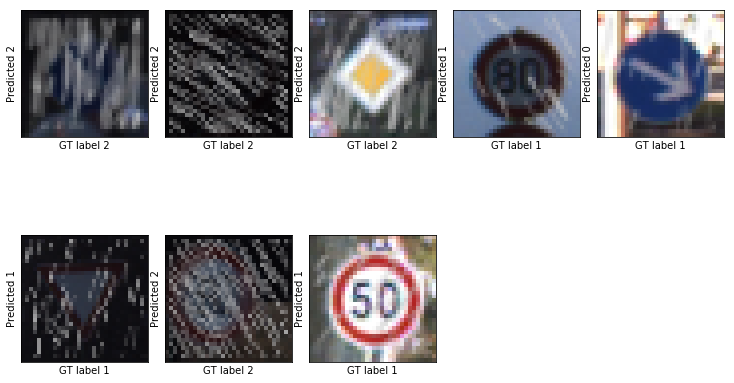

In [0]:
look_up_path_r = root_path + "TSD/RANDOM/{}/".format("RAIN")
rain_test_set, rain_correct_labels, rain_unprocessed =  create_test_set("RAIN", look_up_path_r, 8)
y_classes_rain = evaluate_test_images(deep_cnn_rain, rain_test_set, deep=True )
display_images(rain_unprocessed, rain_correct_labels, y_classes_rain)
print(calculate_accuracy(rain_correct_labels, y_classes_rain))


9000
EFFECT DARKNESS  + Size of the test images 25
(25, 32, 32, 3)
24.0


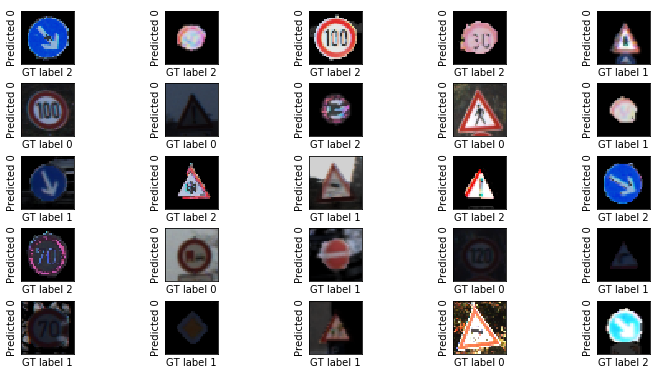

In [0]:

look_up_path = root_path + "TSD/RANDOM/{}/".format("DARKNESS")
darkness_test_set, darkness_correct_labels, darkness_unprocessed =  create_test_set("DARKNESS", look_up_path, 25)
y_classes_darkness = evaluate_test_images(deep_cnn_darkness, darkness_test_set, deep=True )
display_images(darkness_unprocessed, darkness_correct_labels, y_classes_darkness)
print(calculate_accuracy(darkness_correct_labels, y_classes_darkness))


In [0]:
mb_path = root_path + "TSD/RANDOM/{}/".format("MOTIONBLUR")
mb_test_set, mb_correct_labels, mb_unprocessed =  create_test_set(effect_type, mb_path, 20)
y_classes_mb = evaluate_test_images(deep_cnn_motionblur, mb_test_set, deep=True )
display_images(mb_unprocessed, mb_correct_labels, y_classes_mb)
print(calculate_accuracy(mb_correct_labels, y_classes_mb))

9000
EFFECT MOTIONBLUR  + Size of the test images 20
(20, 32, 32, 3)


NameError: ignored

0.0

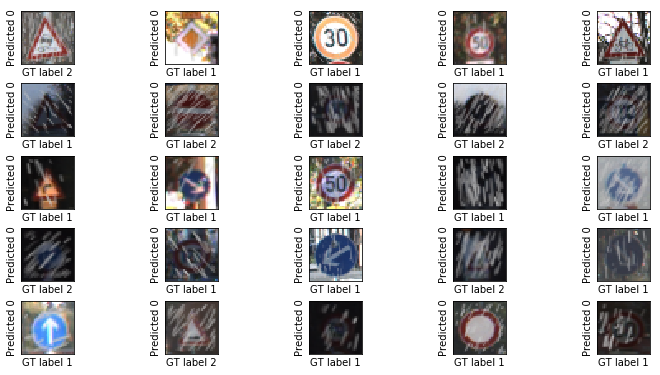

In [0]:
y_classes_mb_mixed = evaluate_test_images(deep_cnn_motionblur, rain_test_set, deep=True )
display_images(rain_unprocessed, rain_correct_labels, y_classes_mb_mixed)
calculate_accuracy(rain_correct_labels, y_classes_mb_mixed)

EFFECT MOTIONBLUR_DARKNESS  + Size of the test images 20
(20, 32, 32, 3)


90.0

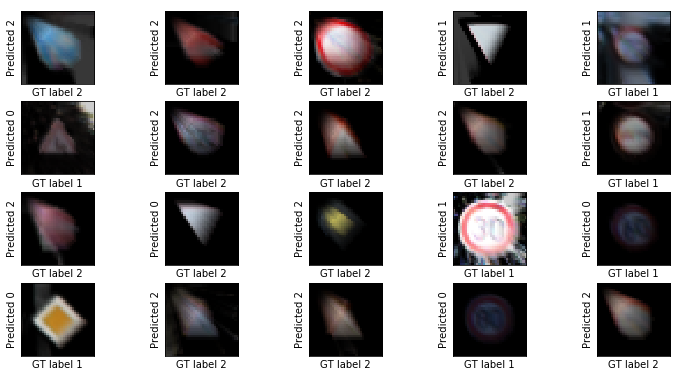

In [0]:
mix_path = root_path + "TSD/RANDOM/{}/".format("MOTIONBLUR_DARKNESS")
efftyp = "MOTIONBLUR_DARKNESS"
test_set, correct_labels, unprocessed =  create_test_set(efftyp, mix_path, 20)
y_classes_mb = evaluate_test_images(deep_cnn_motionblur, test_set, deep=True)
y_classes_dk = evaluate_test_images(deep_cnn_darkness, test_set, deep=True)
display_images(unprocessed, correct_labels, y_classes_mb)
calculate_accuracy(correct_labels, y_classes_dk)

400
EFFECT RAIN_MOTIONBLUR_DARKNESS  + Size of the test images 10
(10, 32, 32, 3)
MOTIONBLUR 100.0
RAIN 80.0
DARKNESS 90.0


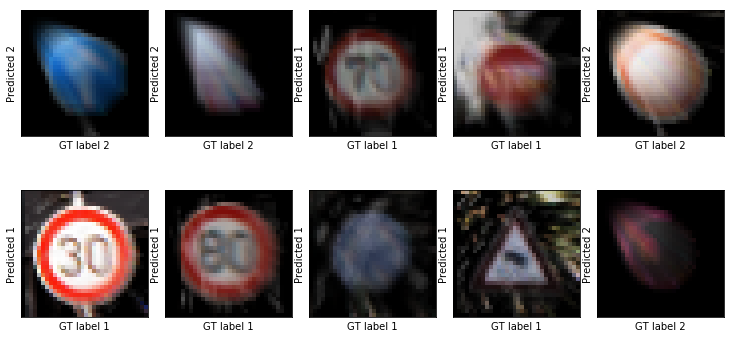

In [0]:
mix_path = root_path + "TSD/RANDOM/{}/".format("RAIN_MOTIONBLUR_DARKNESS")
efftyp = "RAIN_MOTIONBLUR_DARKNESS"
test_set, correct_labels, unprocessed =  create_test_set(efftyp, mix_path, 10)
y_classes_mb = evaluate_test_images(deep_cnn_mb, test_set, deep=True)
y_classes_dk = evaluate_test_images(deep_cnn_darkness, test_set, deep=True)
y_classes_rain = evaluate_test_images(deep_cnn_rain, test_set, deep=True)
display_images(unprocessed, correct_labels, y_classes_mb)
print("MOTIONBLUR {}".format(calculate_accuracy(correct_labels, y_classes_mb)))
print("RAIN {}".format(calculate_accuracy(correct_labels, y_classes_rain)))     
print("DARKNESS {}".format(calculate_accuracy(correct_labels, y_classes_dk)))        